In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fftn, ifftn, fftfreq
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [8, 8]

# Parameters
N = 16  # Grid size
L = 2 * np.pi  # Domain size
nu = 0.01  # Kinematic viscosity
dt = 0.01  # Time step
T = 1 # Total simulation time

# Grid setup
x = np.linspace(0, L, N, endpoint=False)
y = np.linspace(0, L, N, endpoint=False)
X, Y = np.meshgrid(x, y)

# Wavenumbers for Fourier space
KX = fftfreq(N, d=L/N) * L
KY = fftfreq(N, d=L/N) * L
# KX, KY = np.meshgrid(kx, ky)
K2 = KX * KY
K2[K2 == 0] = 1  # Avoid division by zero

# Initial condition: Taylor-Green vortex
A = 1.0
B = 1.0
u = A * np.cos(X) * np.sin(Y)
v = B * np.sin(X) * -np.cos(Y)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Fourier transforms of the velocity field
u_hat = fftn(u)
v_hat = fftn(v)

def compute_vorticity(u_hat, v_hat):
    # Compute vorticity in Fourier space
    omega_x_hat = 1j * (KY * u_hat - KX * v_hat)
    omega_y_hat = 1j * (KX * v_hat - KY * u_hat)
    return omega_x_hat, omega_y_hat

omega_x_hat, omega_y_hat = compute_vorticity(u_hat, v_hat)


In [3]:
def rk4(f, t: float, y: np.ndarray, dt: float) -> np.ndarray:
    """
    Implements the fourth-order Runge-Kutta method for numerical integration
    of multidimensional fields.

    Parameters
    ----------
    f : function
        The function to be integrated. It should take two arguments: time t
        and field y.
    t : float
        The current time.
    y : array_like
        The current value of the field.
    dt : float
        The time step for the integration.

    Returns
    -------
    dy : np.ndarray
        The increment of the field required to obtain the value at t + dt.
    """
    k1 = f(t, y)
    k2 = f(t + dt / 2, y + dt / 2 * k1)
    k3 = f(t + dt / 2, y + dt / 2 * k2)
    k4 = f(t + dt, y + dt * k3)
    return dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)



def nonlinear_term(u_hat, v_hat):
    # Compute the nonlinear term (u x omega) in real space
    u = np.real(ifftn(u_hat))
    v = np.real(ifftn(v_hat))
    omega_x_hat, omega_y_hat = compute_vorticity(u_hat, v_hat)
    omega_x = np.real(ifftn(omega_x_hat))
    omega_y = np.real(ifftn(omega_y_hat))
    ux_omega = u * omega_x + v * omega_y
    return fftn(ux_omega)

def rhs(t, y):
    # Right-hand side of the Navier-Stokes equations in Fourier space
    u_hat, v_hat = np.split(y, 2)
    u_hat = u_hat.reshape((N, N))
    v_hat = v_hat.reshape((N, N))
    nonlinear = nonlinear_term(u_hat, v_hat)
    u_rhs_hat = nonlinear + nu * X**2 * u_hat
    v_rhs_hat = nonlinear + nu * Y**2 * v_hat
    return np.concatenate([u_rhs_hat.ravel(), v_rhs_hat.ravel()])

def rk4_step(u_hat, v_hat, dt):
    y = np.concatenate([u_hat.ravel(), v_hat.ravel()])
    dy = rk4(rhs, 0, y, dt)
    u_hat, v_hat = np.split(dy, 2)
    return u_hat.reshape((N, N)), v_hat.reshape((N, N))

# Main time-stepping loop
t = 0
while t < T:
    u_hat, v_hat = rk4_step(u_hat, v_hat, dt)
    t += dt


In [4]:
def analytical_solution(t, A, nu, X, Y):
    u_x = A * np.cos(X) * np.sin(Y) * np.exp(-2 * nu * t)
    u_y = -A * np.sin(X) * np.cos(Y) * np.exp(-2 * nu * t)
    return u_x, u_y

u_analytical, v_analytical = analytical_solution(T, A, nu, X, Y)


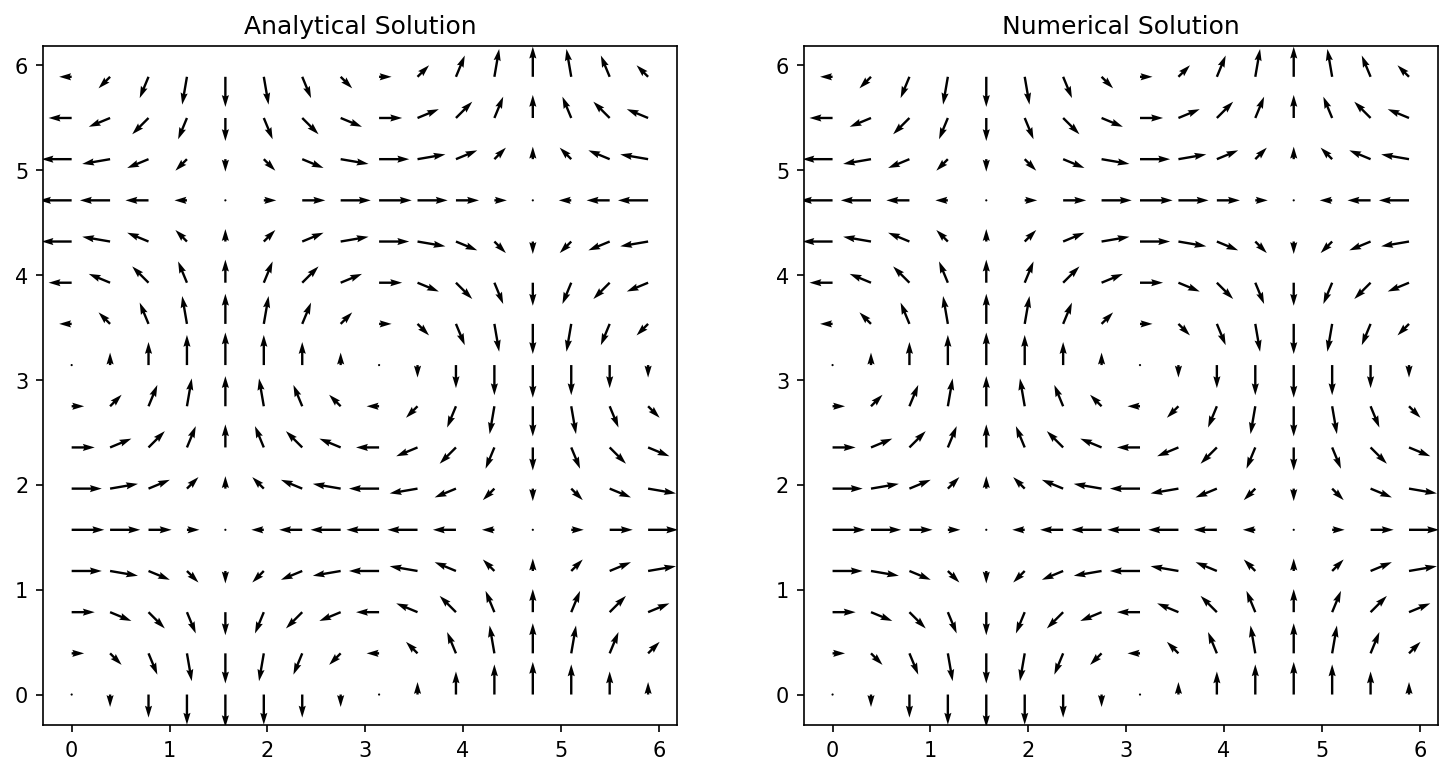

Error in u: 7.841589386454042
Error in v: 7.841589386454042


In [5]:
# Compute the numerical solution in real space
u_numerical = np.real(ifftn(u_hat))
v_numerical = np.real(ifftn(v_hat))

# Plot comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Analytical Solution")
plt.quiver(X, Y, u_analytical, v_analytical)

plt.subplot(1, 2, 2)
plt.title("Numerical Solution")
plt.quiver(X, Y, u_numerical, v_numerical)

plt.show()

# Calculate error
error_u = np.linalg.norm(u_numerical - u_analytical)
error_v = np.linalg.norm(v_numerical - v_analytical)
print(f"Error in u: {error_u}")
print(f"Error in v: {error_v}")
